In [1]:
import tensorflow as tf
from tensorflow.keras.metrics import *
from tensorflow.keras.layers import *
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from hausdorff import hausdorff_distance
#import lr_scheduler
from tensorflow.keras.regularizers import l2

import os
import random
import numpy as np
from tqdm import tqdm
from skimage.io import imread,imshow
from skimage.morphology import label
from skimage.transform import resize
import matplotlib.pyplot as plt
import datetime

In [2]:
TRAIN_PATH="DRIVE/training/"
TEST_PATH="DRIVE/test/"

In [3]:
train_ids=next(os.walk(TRAIN_PATH+'images/'))[2][:]
test_ids=next(os.walk(TEST_PATH+'images/'))[2][:]
print(len(train_ids))

20


In [4]:
input_height = IMG_HEIGHT = 256
input_width = IMG_WIDTH = 256
IMG_CHANNELS = 3

In [5]:

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + 'images/' + id_
    img = imread(path)[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img #/ 255. #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask_path = TRAIN_PATH + 'mask/' + id_[:-4] + '_mask.gif'
    mask = imread(mask_path)
    mask = np.expand_dims(mask, axis=-1)
    mask = resize(mask, (input_width, input_height), mode='constant', preserve_range=True)
    mask = mask/255
    Y_train[n][mask > 0.] = 1.

print('Resizing test images and masks')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):   
    path = TEST_PATH + 'images/' + id_
    img = imread(path)[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img #/ 255. #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask_path = TEST_PATH + 'mask/' + id_[:-4] + '_mask.gif'
    mask = imread(mask_path)
    mask = np.expand_dims(mask, axis=-1)
    mask = resize(mask, (input_width, input_height), mode='constant', preserve_range=True)
    mask = mask/255
    Y_test[n][mask > 0.] = 1.

Resizing training images and masks


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\manda\AppData\Local\Temp\ipykernel_43096\727015007.py:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.28it/s]


Resizing test images and masks


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\manda\AppData\Local\Temp\ipykernel_43096\727015007.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.37it/s]


In [6]:
print(X_train.shape, Y_test.shape)

(20, 256, 256, 3) (20, 256, 256, 1)


C:\Users\manda\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


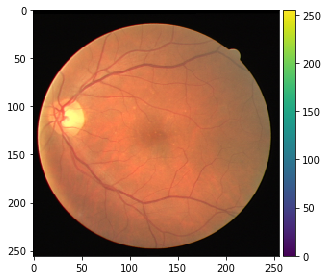

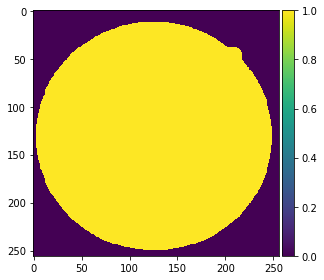

In [7]:
ix=0
imshow(X_train[ix].astype('int'))
plt.show()
imshow(np.squeeze(Y_train[ix].astype('int')))
plt.show()

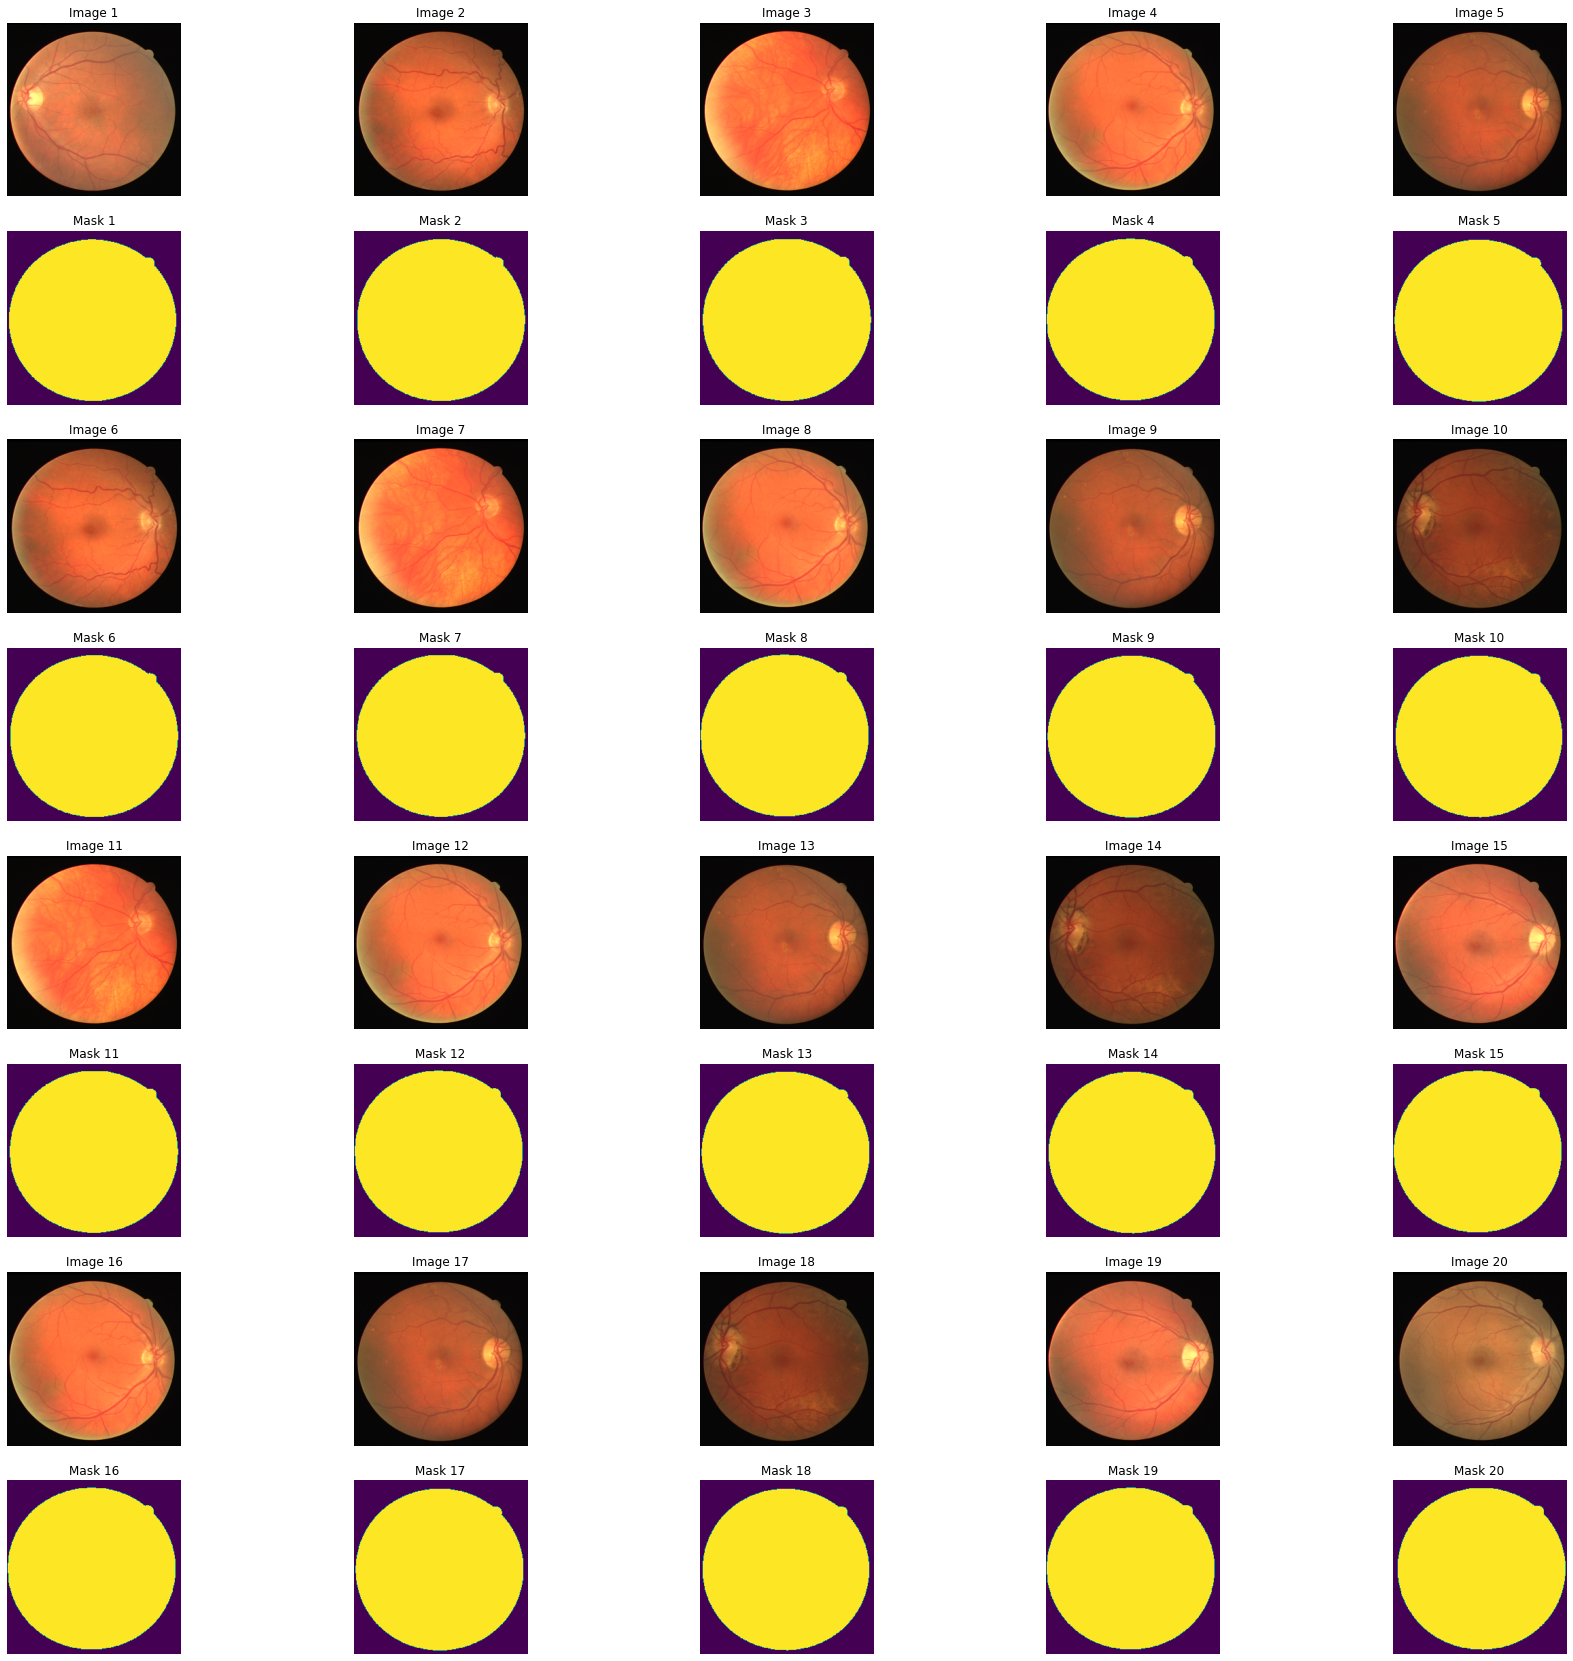

In [8]:
plt.figure(figsize=(30,30))
x, y = 5, 4
count=1
for i in range(y):
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i+j
        plt.imshow(X_train[pos].astype('int'))
        plt.title('Image {}'.format(count))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        plt.imshow(np.squeeze(Y_train[pos].astype('int')))
        plt.title('Mask {}'.format(count))
        plt.axis('off')
        count = count + 1
plt.show()

In [9]:
def expend_as(tensor, rep):
     return Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

def double_conv_layer(x, filter_size, size, dropout, batch_norm=False):
    axis = 3
    conv = SeparableConv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = SeparableConv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = Dropout(dropout)(conv)

    shortcut = Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = BatchNormalization(axis=axis)(shortcut)

    res_path = add([shortcut, conv])
    return res_path

def encoder(inputs):
    num_filters = [16, 32, 64, 128]
    skip_connections = []
    x = inputs

    for i, f in enumerate(num_filters):
        a = double_conv_layer(x, 3, f, 0.1, True)
        skip_connections.append(a)
        x = MaxPooling2D(pool_size=(2, 2))(a)
    
    return x, skip_connections

def bottleneck(inputs):
    x = inputs
    f = 256
    
    x3 = double_conv_layer(x, 3, f, 0.1, True)
    
    return x3

def decoder(inputs, skip_connections):
    num_filters = [128, 64, 32, 16]
    skip_connections.reverse()
    x = inputs
    batch_norm = True
    
    for i, f in enumerate(num_filters):
        
        x_up = UpSampling2D(size=(2, 2), data_format="channels_last")(x)
        x_att = concatenate([x_up, skip_connections[i]], axis=-1)
        
        x = double_conv_layer(x_att, 3, f, 0.1, True)
    return x

def output(inputs):
    x = Conv2D(1, kernel_size=(1,1))(inputs)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)
    
    return x

In [10]:
def random_resize_crop(image, scale=[0.75, 1.0], crop_size=128):
    if crop_size == 32:
        image_shape = 48
        image = tf.image.resize(image, (image_shape, image_shape))
    else:
        image_shape = 96
        image = tf.image.resize(image, (image_shape, image_shape))
    size = tf.random.uniform(
        shape=(1,),
        minval=scale[0] * image_shape,
        maxval=scale[1] * image_shape,
        dtype=tf.float32,
    )
    size = tf.cast(size, tf.int32)[0]
    crop = tf.image.random_crop(image, (size, size, 3))
    crop_resize = tf.image.resize(crop, (crop_size, crop_size))
    return crop_resize

def flip_random_crop(image):
    image = tf.image.random_flip_left_right(image)
    image = random_resize_crop(image, crop_size=CROP_TO)
    return image


@tf.function
def float_parameter(level, maxval):
    return tf.cast(level * maxval / 10.0, tf.float32)


@tf.function
def sample_level(n):
    return tf.random.uniform(shape=[1], minval=0.1, maxval=n, dtype=tf.float32)

def rotation(image):
    augmented_image = tf.image.rot90(image)
    return augmented_image

@tf.function
def solarize(image, level=6):
    threshold = float_parameter(sample_level(level), 1)
    return tf.where(image < threshold, image, 255 - image)

def color_jitter(x, strength=0.5):
    x = tf.image.random_brightness(x, max_delta=0.8 * strength)
    x = tf.image.random_contrast(
        x, lower=1 - 0.8 * strength, upper=1 + 0.8 * strength
    )
    x = tf.image.random_saturation(
        x, lower=1 - 0.8 * strength, upper=1 + 0.8 * strength
    )
    x = tf.image.random_hue(x, max_delta=0.2 * strength)
    x = tf.clip_by_value(x, 0, 255)
    return x


def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x


def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x


def custom_augment(image):
    image = tf.cast(image, tf.float32)
    image = flip_random_crop(image)
    image = random_apply(rotation, image, p=0.5)
    #image = random_apply(color_jitter, image, p=0.9)
    #image = random_apply(color_drop, image, p=0.3)
    #image = random_apply(solarize, image, p=0.3)
    return image

In [11]:
AUTO = tf.data.AUTOTUNE
CROP_TO = IMG_HEIGHT
SEED = 42
BATCH_SIZE = 4
ssl_ds_one = tf.data.Dataset.from_tensor_slices(X_train)
ssl_ds_one = (
    ssl_ds_one.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

ssl_ds_two = tf.data.Dataset.from_tensor_slices(X_train)
ssl_ds_two = (
    ssl_ds_two.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# We then zip both of these datasets.
ssl_ds = tf.data.Dataset.zip((ssl_ds_one, ssl_ds_two))

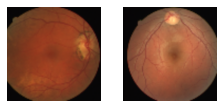

In [12]:
sample_images_one = next(iter(ssl_ds_one))
plt.figure(figsize=(10, 10))
for n in range(2):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_one[n].numpy().astype("int"))
    #print(sample_images_one[n].numpy().shape)
    plt.axis("off")
plt.show()

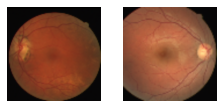

In [13]:
sample_images_two = next(iter(ssl_ds_two))
plt.figure(figsize=(10, 10))
for n in range(2):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_two[n].numpy().astype("int"))
    plt.axis("off")
plt.show()

In [14]:
def off_diagonal(x):
    n = tf.shape(x)[0]
    flattened = tf.reshape(x, [-1])[:-1]
    off_diagonals = tf.reshape(flattened, (n-1, n+1))[:, 1:]
    return tf.reshape(off_diagonals, [-1])


def normalize_repr(z):
    z_norm = (z - tf.reduce_mean(z, axis=0)) / tf.math.reduce_std(z, axis=0)
    return z_norm


def compute_loss(z_a, z_b, lambd):
    # Get batch size and representation dimension.
    batch_size = tf.cast(tf.shape(z_a)[0], z_a.dtype)
    repr_dim = tf.shape(z_a)[1]

    # Normalize the representations along the batch dimension.
    z_a_norm = normalize_repr(z_a)
    z_b_norm = normalize_repr(z_b)

    # Cross-correlation matrix.
    c = tf.matmul(z_a_norm, z_b_norm, transpose_a=True) / batch_size

    # Loss.
    on_diag = tf.linalg.diag_part(c) + (-1)
    on_diag = tf.reduce_sum(tf.pow(on_diag, 2))
    off_diag = off_diagonal(c)
    off_diag = tf.reduce_sum(tf.pow(off_diag, 2))
    loss = on_diag + (lambd * off_diag)
    return loss 

In [15]:
class BarlowTwins(tf.keras.Model):
    def __init__(self, encoder, lambd=5e-3):
        super(BarlowTwins, self).__init__()
        self.encoder = encoder
        self.lambd = lambd
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        # Unpack the data.
        ds_one, ds_two = data

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            z_a, z_b = self.encoder(ds_one, training=True), self.encoder(ds_two, training=True)
            loss = compute_loss(z_a, z_b, self.lambd) 

        # Compute gradients and update the parameters.
        gradients = tape.gradient(loss, self.encoder.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.encoder.trainable_variables))

        # Monitor loss.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [16]:
class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    Implements an LR scheduler that warms up the learning rate for some training steps
    (usually at the beginning of the training) and then decays it
    with CosineDecay (see https://arxiv.org/abs/1608.03983)
    """

    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        learning_rate = (
            0.5
            * self.learning_rate_base
            * (
                1
                + tf.cos(
                    self.pi
                    * (tf.cast(step, tf.float32) - self.warmup_steps)
                    / float(self.total_steps - self.warmup_steps)
                )
            )
        )

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

In [17]:
PROJECT_DIM = IMG_HEIGHT/2
BATCH_SIZE = 8
EPOCHS = 100
WEIGHT_DECAY = 5e-4
TRAIN_FLG = 0 # 0 - No Training, 1 - Training
val_split = 0.3

STEPS_PER_EPOCH = len(X_train) // BATCH_SIZE
TOTAL_STEPS = STEPS_PER_EPOCH * EPOCHS
WARMUP_EPOCHS = int(EPOCHS * 0.1)
WARMUP_STEPS = int(WARMUP_EPOCHS * STEPS_PER_EPOCH)

lr_decayed_fn = WarmUpCosine(
    learning_rate_base=1e-3,
    total_steps=EPOCHS * STEPS_PER_EPOCH,
    warmup_learning_rate=0.0,
    warmup_steps=WARMUP_STEPS
)

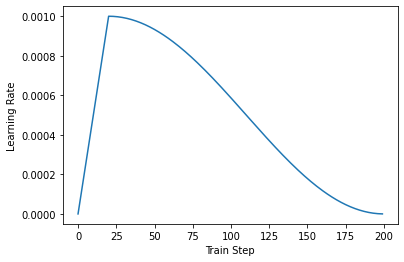

In [18]:
# Visualize the LR schedule
plt.plot(lr_decayed_fn(tf.range(EPOCHS*STEPS_PER_EPOCH, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
plt.show()

In [19]:
def projection_head(x, hidden_dim=128):
    """Constructs the projection head."""
    for i in range(2):
        x = Dense(
            hidden_dim,
            name=f"projection_layer_{i}",
            kernel_regularizer=l2(WEIGHT_DECAY),
        )(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    outputs = Dense(hidden_dim, name="projection_output")(x)
    return outputs

def build_encoder(shape, hidden_dim=128):
    inputs = Input(shape)
    s = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
    #s = inputs
    x, skip_1 = encoder(s)
    
    x = bottleneck(x)
    
    # Projections
    trunk_output = GlobalAvgPool2D()(x)
    projection_outputs = projection_head(trunk_output, hidden_dim=hidden_dim)

    model = Model(inputs, projection_outputs)
    return model, skip_1

In [20]:
unet_enc, skip_connetions = build_encoder((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), hidden_dim=PROJECT_DIM)
unet_enc.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 separable_conv2d (SeparableCon  (None, 256, 256, 16  91         ['rescaling[0][0]']              
 v2D)                           )                                                                 
                                                                                              

                                                                                                  
 batch_normalization_7 (BatchNo  (None, 64, 64, 64)  256         ['separable_conv2d_5[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 conv2d_2 (Conv2D)              (None, 64, 64, 64)   2112        ['max_pooling2d_1[0][0]']        
                                                                                                  
 activation_5 (Activation)      (None, 64, 64, 64)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 64, 64, 64)  256         ['conv2d_2[0][0]']               
 rmalization)                                                                                     
          

 projection_layer_1 (Dense)     (None, 128)          16512       ['activation_10[0][0]']          
                                                                                                  
 batch_normalization_16 (BatchN  (None, 128)         512         ['projection_layer_1[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 activation_11 (Activation)     (None, 128)          0           ['batch_normalization_16[0][0]'] 
                                                                                                  
 projection_output (Dense)      (None, 128)          16512       ['activation_11[0][0]']          
                                                                                                  
Total params: 255,467
Trainable params: 251,979
Non-trainable params: 3,488
_________________________________

In [25]:
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn, momentum=0.9)
barlow_twins = BarlowTwins(unet_enc)
barlow_twins.compile(optimizer=optimizer)
if TRAIN_FLG:
    print("Training")
    barlow_twins.encoder.get_weights()[0]
    history = barlow_twins.fit(ssl_ds, epochs=EPOCHS)
    barlow_twins.encoder.save("barlow")
    plt.plot(history.history["loss"])
    plt.grid()
    plt.title("Barlow Twin Loss")
    plt.show()
elif not TRAIN_FLG:
    print("Loading training weights")
    barlow_twins.encoder.load_weights("barlow")

Loading training weights


PermissionError: [Errno 13] Unable to open file (unable to open file: name = 'barlow', errno = 13, error message = 'Permission denied', flags = 0, o_flags = 0)